CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
print("CUDA Available?", cuda)
print("device ", device)

CUDA Available? True
device  cuda


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 99464137.89it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 76571235.03it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26281675.11it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19823651.16it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [5]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

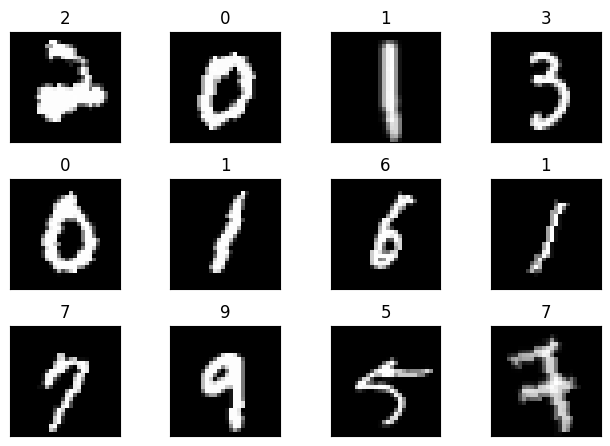

In [7]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [8]:
class Net(nn.Module):
    #This defines the structure of the NN.
    #Total Params changes after adding bias =True/False
    def __init__(self):
        super(Net, self).__init__()
        # r_in:1, n_in:28, j_in:1, s:1, r_out:3, n_out:26, j_out:1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, bias=False)
        # r_in:3, n_in:26, j_in:1, s:1, r_out:5, n_out:24, j_out:1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, bias=False)
        # r_in:5, n_in:24, j_in:1, s:2, r_out:6, n_out:12, j_out:2
        #maxpool
        # r_in:6, n_in:12, j_in:2, s:1, r_out:10, n_out:10, j_out:2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, bias=False)
        # r_in:10, n_in:10, j_in:2, s:1, r_out:14, n_out:8, j_out:2
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, bias=False)
        # r_in:14, n_in:8, j_in:2, s:2, r_out:16, n_out:4, j_out:4
        #maxpool
        
        self.fc1 = nn.Linear(4096, 50, bias=False)
        self.fc2 = nn.Linear(50, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = F.relu(self.conv3(x))
        x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
        x = x.view(-1, 4096)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

In [10]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 9

In [11]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.7601 Batch_id=117 Accuracy=28.63: 100%|██████████| 118/118 [00:29<00:00,  4.02it/s]


Test set: Average loss: 1.7821, Accuracy: 4412/10000 (44.12%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.2476 Batch_id=117 Accuracy=77.70: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


Test set: Average loss: 0.1261, Accuracy: 9636/10000 (96.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1910 Batch_id=117 Accuracy=95.14: 100%|██████████| 118/118 [00:23<00:00,  5.02it/s]


Test set: Average loss: 0.0748, Accuracy: 9791/10000 (97.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.2130 Batch_id=117 Accuracy=96.41: 100%|██████████| 118/118 [00:22<00:00,  5.21it/s]


Test set: Average loss: 0.0570, Accuracy: 9828/10000 (98.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1224 Batch_id=117 Accuracy=97.19: 100%|██████████| 118/118 [00:22<00:00,  5.21it/s]


Test set: Average loss: 0.0543, Accuracy: 9841/10000 (98.41%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0296 Batch_id=117 Accuracy=97.55: 100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


Test set: Average loss: 0.0399, Accuracy: 9870/10000 (98.70%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0266 Batch_id=117 Accuracy=97.84: 100%|██████████| 118/118 [00:21<00:00,  5.38it/s]


Test set: Average loss: 0.0382, Accuracy: 9877/10000 (98.77%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0591 Batch_id=117 Accuracy=97.90: 100%|██████████| 118/118 [00:21<00:00,  5.52it/s]


Test set: Average loss: 0.0358, Accuracy: 9891/10000 (98.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0327 Batch_id=117 Accuracy=98.09: 100%|██████████| 118/118 [00:21<00:00,  5.53it/s]


Test set: Average loss: 0.0307, Accuracy: 9898/10000 (98.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0498 Batch_id=117 Accuracy=98.37: 100%|██████████| 118/118 [00:21<00:00,  5.40it/s]


Test set: Average loss: 0.0312, Accuracy: 9904/10000 (99.04%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0682 Batch_id=117 Accuracy=98.47: 100%|██████████| 118/118 [00:22<00:00,  5.27it/s]


Test set: Average loss: 0.0290, Accuracy: 9901/10000 (99.01%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0103 Batch_id=117 Accuracy=98.41: 100%|██████████| 118/118 [00:22<00:00,  5.25it/s]


Test set: Average loss: 0.0263, Accuracy: 9909/10000 (99.09%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0220 Batch_id=117 Accuracy=98.54: 100%|██████████| 118/118 [00:23<00:00,  4.99it/s]


Test set: Average loss: 0.0252, Accuracy: 9914/10000 (99.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0416 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


Test set: Average loss: 0.0247, Accuracy: 9918/10000 (99.18%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0325 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [00:22<00:00,  5.21it/s]


Test set: Average loss: 0.0241, Accuracy: 9916/10000 (99.16%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0600 Batch_id=117 Accuracy=98.97: 100%|██████████| 118/118 [00:22<00:00,  5.23it/s]


Test set: Average loss: 0.0219, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0125 Batch_id=117 Accuracy=99.02: 100%|██████████| 118/118 [00:22<00:00,  5.21it/s]


Test set: Average loss: 0.0210, Accuracy: 9933/10000 (99.33%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0084 Batch_id=117 Accuracy=99.07: 100%|██████████| 118/118 [00:22<00:00,  5.20it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0081 Batch_id=117 Accuracy=99.00: 100%|██████████| 118/118 [00:22<00:00,  5.22it/s]


Test set: Average loss: 0.0210, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0231 Batch_id=117 Accuracy=99.02: 100%|██████████| 118/118 [00:21<00:00,  5.46it/s]


Test set: Average loss: 0.0203, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-03.


Text(0.5, 1.0, 'Test Accuracy')

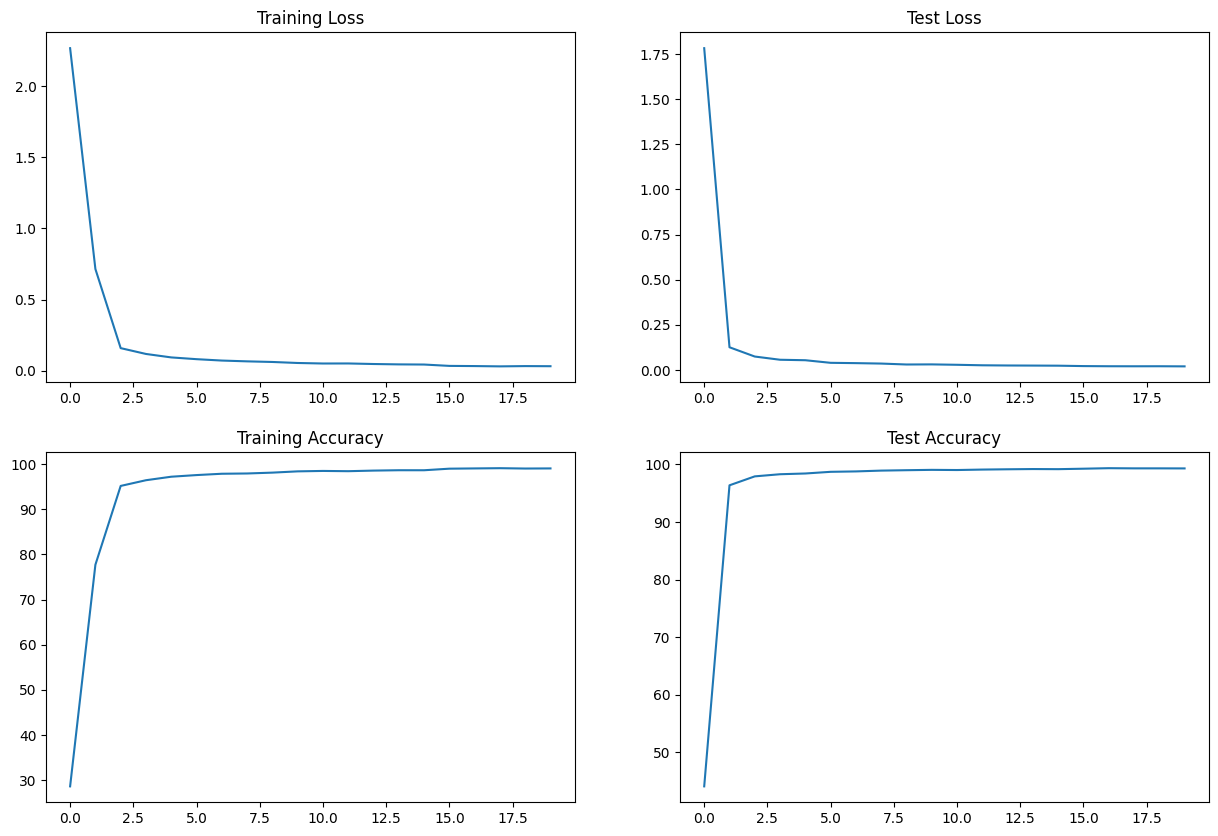

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Text(0.5, 1.0, 'Test Accuracy')

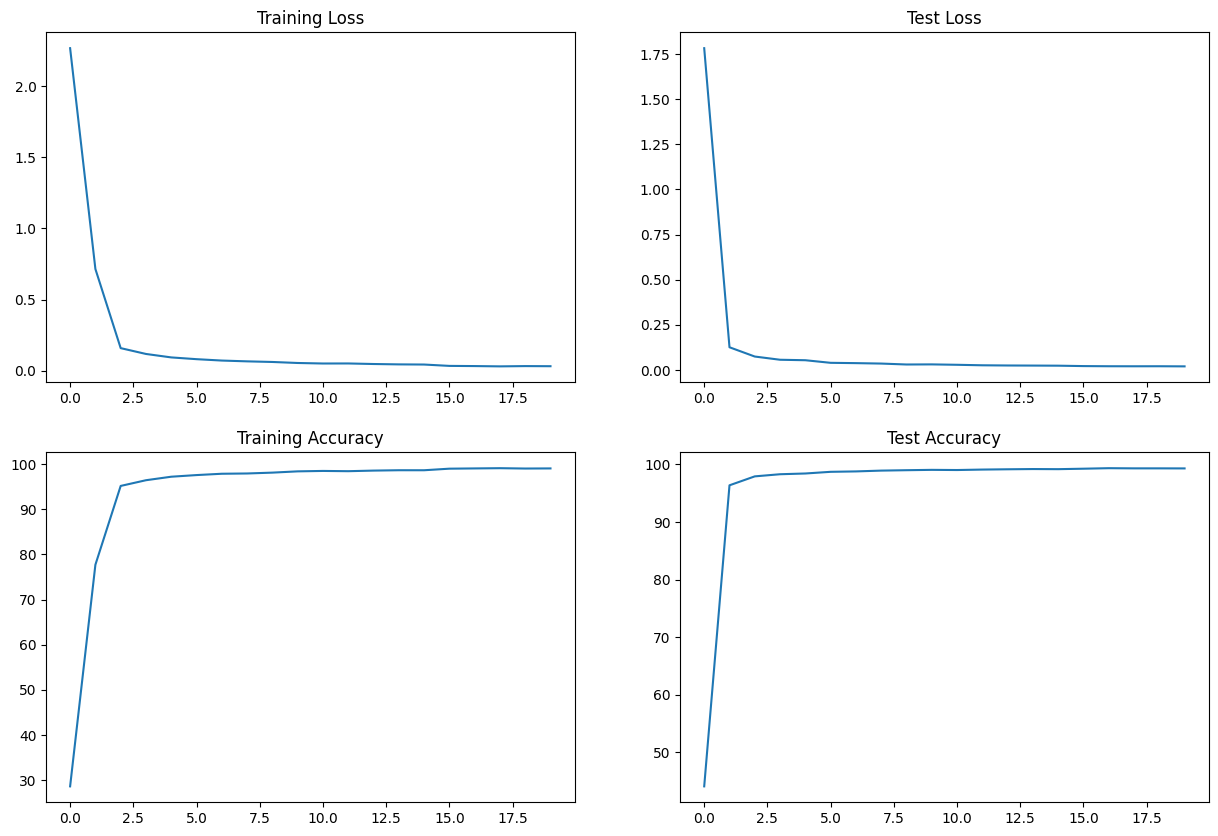

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [14]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
            Conv2d-2           [-1, 64, 24, 24]          18,432
            Conv2d-3          [-1, 128, 10, 10]          73,728
            Conv2d-4            [-1, 256, 8, 8]         294,912
            Linear-5                   [-1, 50]         204,800
            Linear-6                   [-1, 10]             500
Total params: 592,660
Trainable params: 592,660
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.93
----------------------------------------------------------------
